In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os

from glob import glob
from collections import Counter
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

import utils.merge_tools as M

pd.set_option('future.no_silent_downcasting', True)

In [2]:
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

## Load Data

Function heavily weights random sampling towards minority class.

In [3]:
n_ids = 0

df = M.merge_n_case_ids(
    n_ids=n_ids,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=True,
    as_pandas=False,
    random_state=28
)
case_ids_list = list(df['case_id'])

df_rest = M.merge_n_case_ids(
    n_ids=n_ids,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=False,
    as_pandas=False,
    case_id_list=case_ids_list,
    random_state=28
)

In [4]:
# Merge personal and non-personal
df_full = df.join(df_rest, on=['case_id', 'date_decision', 'WEEK_NUM'], how='left')

# Separate 'date_decision'
df_dd = M.separate_dates(df_full, ['date_decision'])
df_full = pl.concat([df_full, df_dd], how='horizontal')
df_full = df.drop(['date_decision', 'case_id', 'MONTH', 'WEEK_NUM'])

## Data Cleaning

In [5]:
Counter(df_full.dtypes)

Counter({Float64: 743,
         Int8: 493,
         Int32: 66,
         UInt32: 40,
         Boolean: 14,
         Int64: 1})

In [6]:
# Create is_null columns
df_is_null = M.create_is_null_cols(df_full)

In [7]:
# Create pandas DataFrame
df_new = df_is_null.to_pandas()

# Drop empty columns
df_new = df_new.dropna(how='all', axis=1)

# Create total nulls column
nulls_col = pd.Series(df_new.isnull().sum(axis=1), name='total_nulls')
df_new = pd.concat([df_new, nulls_col], axis=1)

In [8]:
# Get object columns and cast as bool
obj_cols = df_new.select_dtypes('object').columns
for col in obj_cols:
    df_new[col] = df_new[col].fillna(False).astype(bool)

In [9]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
df_filtered = df_new[df_new.columns[df_new.isnull().mean() < missing_threshold]]

In [10]:
df_new.shape, df_filtered.shape

((1526659, 2561), (1526659, 2222))

## EDA

There appears to be multiple clusters of total nulls by case in the dataset.  We will further investigate at the depth 1 and 2 level.

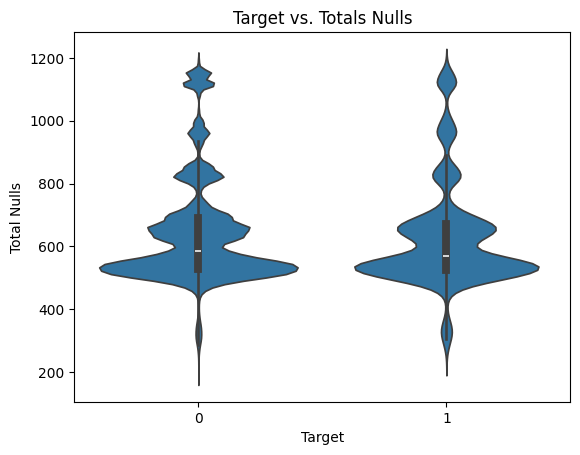

In [11]:
sns.violinplot(data=df_filtered, x='target', y='total_nulls')

plt.title('Target vs. Totals Nulls')
plt.ylabel('Total Nulls')
plt.xlabel('Target')

plt.show()

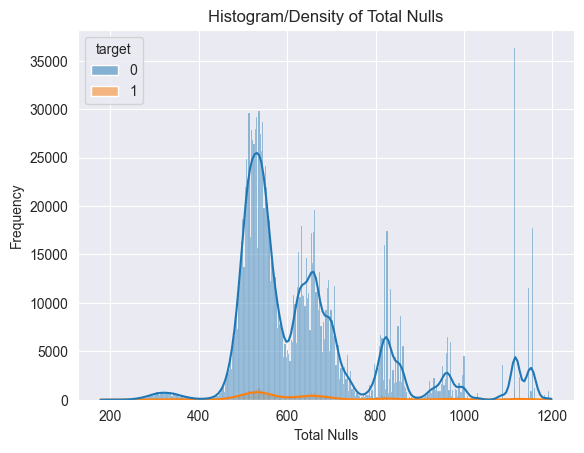

In [12]:
sns.set_style('darkgrid')

sns.histplot(data=df_filtered, x='total_nulls', hue='target', kde=True)

plt.xlabel('Total Nulls')
plt.ylabel('Frequency')
plt.title('Histogram/Density of Total Nulls')

plt.show()

There are 2 peaks in frequency of target being positive by number of nulls in a case.

/var/folders/sp/dv4f3qgx20vb8f6ghm2mh5880000gn/T/ipykernel_12296/2505453769.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_nulls = null_df.groupby('null_bin')['target'].count().reset_index()
/var/folders/sp/dv4f3qgx20vb8f6ghm2mh5880000gn/T/ipykernel_12296/2505453769.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pos_nulls = null_df.groupby('null_bin')['target'].sum().reset_index()


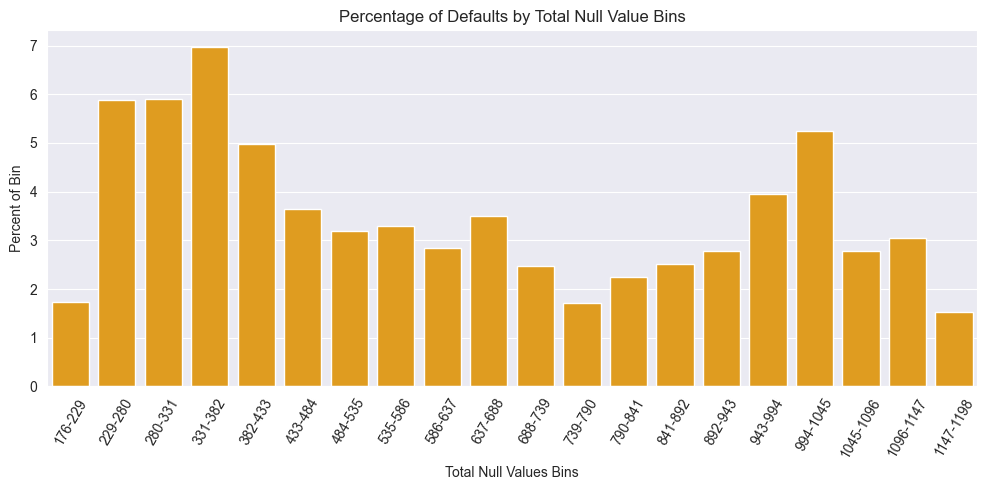

In [13]:
n_bins = 20
null_df = df_filtered[['target', 'total_nulls']].copy()
null_df['null_bin'] = pd.cut(null_df['total_nulls'], bins=n_bins)
total_nulls = null_df.groupby('null_bin')['target'].count().reset_index()
pos_nulls = null_df.groupby('null_bin')['target'].sum().reset_index()

pos_nulls['pct'] = [ i / j * 100 for i,j in zip(pos_nulls['target'], total_nulls['target']) ]

plt.figure(figsize=(10, 5))

bar_2 = sns.barplot(data=pos_nulls, x='null_bin', y='pct', color='orange')


bins_list = total_nulls['null_bin'].unique().tolist()
x_tick_labels = [ f'{int(cat.left)}-{int(cat.right)}' for cat in bins_list ]

plt.xticks(ticks=range(n_bins), labels=x_tick_labels, rotation=60)
plt.xlabel('Total Null Values Bins')
plt.ylabel('Percent of Bin')
plt.title('Percentage of Defaults by Total Null Value Bins')

plt.tight_layout()
plt.show()

In [14]:
df_imputed = df_filtered.copy()

for col in df_imputed.columns:
    if df_imputed[col].isna().sum() > 0:
        df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

In [15]:
df_imputed.head()

,target,empls_employedfrom_796D_distinct,addres_district_368M_freq,addres_zip_823M_freq,conts_role_79M_freq,empls_economicalst_849M_freq,empls_employer_name_740M_freq,addres_district_368M_binary_0,addres_district_368M_binary_1,addres_district_368M_binary_2,...,amtdebitoutgoing_4809440A_median_is_null,amtdepositbalance_4809441A_median_is_null,amtdepositincoming_4809444A_median_is_null,amtdepositoutgoing_4809442A_median_is_null,amtdebitincoming_4809443A_sum_is_null,amtdebitoutgoing_4809440A_sum_is_null,amtdepositbalance_4809441A_sum_is_null,amtdepositincoming_4809444A_sum_is_null,amtdepositoutgoing_4809442A_sum_is_null,total_nulls
0,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,...,True,True,True,True,True,True,True,True,True,664
1,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,...,True,True,True,True,True,True,True,True,True,499
2,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,...,True,True,True,True,True,True,True,True,True,634
3,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,...,True,True,True,True,True,True,True,True,True,960
4,0,1.0,0.99174,0.991968,0.993043,0.993195,0.999999,1.0,0.0,1.0,...,True,True,True,True,True,True,True,True,True,666
